In [1]:
#importing libraries
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

In [2]:
#loading dataset
df = pd.read_csv('FakeNewsNet.csv')
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


# Data preprocessing and EDA


In [3]:
#summarizing data's information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [4]:
#dropping unnecesary columns
df.drop(['news_url','source_domain','tweet_num'],axis = 1,inplace = True)

In [5]:
df.duplicated().sum()

1349

In [6]:
df.drop_duplicates(inplace = True)

<Axes: xlabel='real', ylabel='count'>

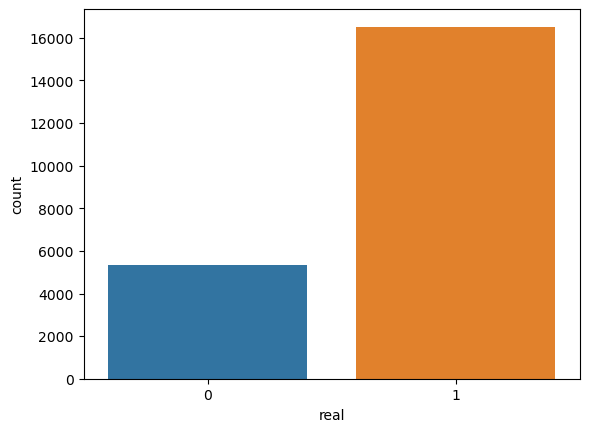

In [7]:
import seaborn as sns
sns.countplot(x=df['real'])

In [8]:
df.isna().sum()

title    0
real     0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21847 entries, 0 to 23195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21847 non-null  object
 1   real    21847 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 512.0+ KB


In [10]:
df['real'].value_counts()

1    16524
0     5323
Name: real, dtype: int64

In [11]:
#lowercasing
df['title'] = df['title'].str.lower()

In [12]:
#punctuation removal
import re
def clean(x):
    x = re.sub('[^a-zA-Z]',' ',x)
    return x
df['title'] = df['title'].apply(clean)

In [13]:
df.head(3)

,title,real
0,kandi burruss explodes over rape accusation on...,1
1,people s choice awards the best red carp...,1
2,sophia bush sends sweet birthday message to o...,1


In [14]:
#stopwords removal and stemming in order to improve model's performance
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
st = PorterStemmer()
def clean2(x):
    x = ' '.join(i for i in x.split() if i not in sw)
    x = ' '.join([st.stem(word) for word in x.split()])
    return x

df['title'] = df['title'].apply(clean2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\odhia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df.head(3)

,title,real
0,kandi burruss explod rape accus real housew at...,1
1,peopl choic award best red carpet look,1
2,sophia bush send sweet birthday messag one tre...,1


In [16]:
df['title'][0]

'kandi burruss explod rape accus real housew atlanta reunion video'

In [17]:
#encoding the words into numbers since algorithms only work with numbers
#the voc-size here is the maximum size of the vocabulary we want our sentences to have
voc_size = 6500
df['title'] = [one_hot(i,voc_size) for i in df['title']]

In [18]:
df['title'][0]

[5096, 6263, 3812, 5659, 3567, 370, 2856, 5324, 3854, 470]

In [19]:
#since the length of each an every sentence in not similar,we do padding in order to make them similar
df['title']=pad_sequences(df['title'],padding = 'pre',maxlen = 30)

In [20]:
#splitting dataset into train and test split
X =df['title']
y = df['real']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.30,random_state=0)

In [21]:
#building LSTM sequential model
model = Sequential([
    Embedding(input_dim = 6500,output_dim = 100),
    Dropout(0.3),
    LSTM(100,return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1,activation = 'sigmoid')
])

In [22]:
#model compilation
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         650000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, None, 100)         80400     
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 

In [23]:
model.fit(X_train,y_train,batch_size =32 ,epochs = 10)

Epoch 1/10


478/478 [==============================] - 15s 19ms/step - loss: 0.5656 - accuracy: 0.7539
Epoch 2/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5596 - accuracy: 0.7546
Epoch 3/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5593 - accuracy: 0.7546
Epoch 4/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5592 - accuracy: 0.7546
Epoch 5/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5587 - accuracy: 0.7546
Epoch 6/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5588 - accuracy: 0.7546
Epoch 7/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5588 - accuracy: 0.7546
Epoch 8/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5584 - accuracy: 0.7546
Epoch 9/10
478/478 [==============================] - 9s 19ms/step - loss: 0.5583 - accuracy: 0.7546
Epoch 10/10
478/478 [==============================] - 9s 18ms/step - loss: 0.5577 - acc

In [24]:
pred = (model.predict(X_test) > 0.5).astype('int32')

205/205 [==============================] - 2s 3ms/step


In [25]:
#checking model's accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,pred))

0.7603356216628527


In [26]:
print(pred)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


## Defining a predictor

In [27]:
x = 'David Cassidy cuts estranged daughter Katie completely out of his willâ€¦ but leaves Â£110,000 to son Beau'
x = x.lower()

In [28]:
x = re.sub('[^a-zA-Z]',' ',x)
x

'david cassidy cuts estranged daughter katie completely out of his will    but leaves           to son beau'

In [29]:
x = ' '.join(i for i in x.split() if i not in sw)
x = ' '.join([st.stem(word) for word in x.split()])

In [30]:
x

'david cassidi cut estrang daughter kati complet leav son beau'

In [31]:
#one hot representation
q= [one_hot(x,voc_size)]
q

[[2844, 5619, 6415, 1494, 3030, 5210, 5707, 3065, 2729, 5894]]

In [32]:
#we do padding since user may be prompted to type long senetences
q=pad_sequences(q,padding = 'pre',maxlen = 30)
q

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 2844, 5619,
        6415, 1494, 3030, 5210, 5707, 3065, 2729, 5894]])

In [33]:
#checking the shape of the input,it's a 2D array
q.shape

(1, 30)

In [34]:
#the output is a probability between 0 and 1
#if it's > than 0.5,then 1(real news) else 0(fake news)
model.predict(q)

1/1 [==============================] - 1s 1s/step


array([[0.9700515]], dtype=float32)

In [35]:
model.save('fakenews.keras')